# Simple Controllers

This Jupyter notebook contains the python code implementation of simple controllers and the algorithm design behind each implementation.


In [1]:
import time
from gym.spaces import Discrete, Box
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..')))
from gym_electric_motor.physical_systems.electric_motors import DcShuntMotor, DcExternallyExcitedMotor, \
    DcPermanentlyExcitedMotor, DcSeriesMotor
from gym_electric_motor.physical_systems import SynchronousMotorSystem, DcMotorSystem
import math
import numpy as np



## Introduction to Controllers

In an industrial plant, a closed-loop control system has the role of keeping a measured physical signal to a predefined value (setpoint). The physical signal, also called controlled variable, can be of any kind, electrical (voltage, current, power), mechanical (position, speed, force, torque), hydraulic (pressure, flow) or thermal (temperature). 

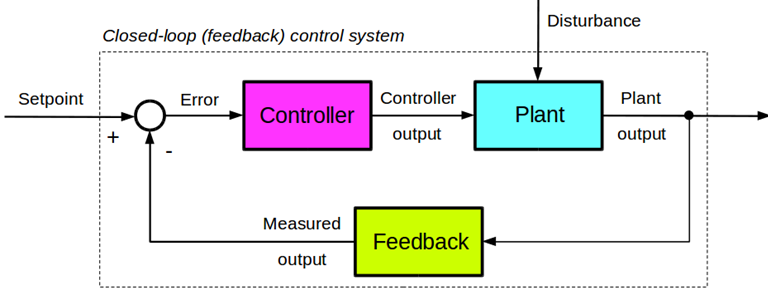





The difference between the controlled variable (measured) and the predefined value(reference) is called error.The input of the controller is the error and the controller output is an actuation signal which is fed to the system/plant.

The difference between the setpoint and the plant output (measured) occurs because of the disturbances which affect the plant (process). The role of the controller is to reject these disturbances and keep the plant output (controlled variable) to the predefined value (setpoint).


In [1]:
class Controller:
    """
      The following is a base class for various controllers along with the motor environments

    """

    @classmethod
    def make(cls, controller_type, environment, **controller_kwargs):
        """
        Args:
            controller_type : Choose among the given set of controllers at the end of this class
            environment : Choose the corresponding motor environment from 'envs' class.

        """
        assert controller_type in _controllers.keys(), f'Controller {controller_type} unknown'
        controller = _controllers[controller_type](environment, **controller_kwargs)
        return controller

    def control(self, state, reference):
        raise NotImplementedError

    def reset(self):
        pass


## On-off control system
 
The on-off control is the simplest form of a controller, which switches ON when the error is positive and switches OFF when the error is zero or negative. An on-off controller doesn’t have intermediate states but only fully ON or fully OFF states. Due to the switching logic, an on-off controller is often called a bang-bang controller or a two-step controller. The response of an On-off controller can be understood from the image below

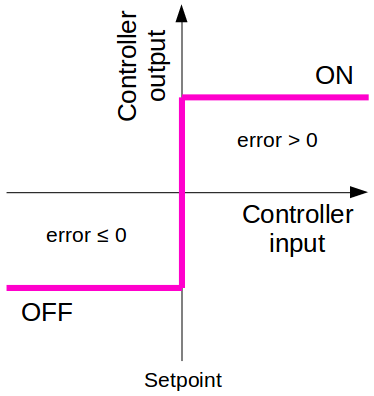


In [ ]:
class OnOffController(Controller):
    """
        The following controller is a simple OnOffController which allows the state to choose high_action when referenced_state is below
        ref_idx and low_action otherwise.A 'Hysteresis' value should be integrated(chosen as 0.01) in this controller because of the
         constant switching and high frequency around the reference_idx.

        Valid for Motors with Discrete Action Space
    """

    def __init__(self, environment, hysteresis=0.01, state_idx=None, reference_idx=0):
        action_space = environment.action_space
        assert type(action_space) is Discrete, 'Not suitable action space for On off controller'
        self._hysteresis = hysteresis
        self._high_action = 1
        if action_space.n in [3, 4]:
            self._low_action = 2
        else:
            self._low_action = 0
        if state_idx is None:
            self._referenced_state = np.argmax(
                environment.reference_generator.referenced_states[environment.state_filter]
            )
        else:
            self._referenced_state = state_idx
        self._ref_idx = reference_idx

    def control(self, state, reference):
        if state[self._referenced_state] < reference[self._ref_idx] - self._hysteresis:
            return self._high_action
        else:
            return self._low_action

## Three Point Control System

Three-point controllers with three switching states feature one input and two outputs switching each output
to "ON", "OFF", or "both OFF" depending on a certain positive or negative deviation of the input signal
from the desired value. The allow the switching of 2 different energy types and have a usually symmetric
"Dead zone" with an upper and lower limit of the deviation where no switching activities take place. 
In the following figure DB2 is the deadzone.

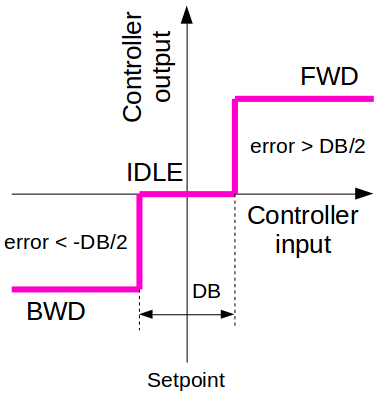

In [3]:
class ThreePointController(Controller):
    """
    Below is an implementation of a 3 point controller: When state_idx is below the reference_idx, it choose high_action and when the
    state_idx is above the reference_idx,it choose low_action. If it is between the reference_idx values, it will choose idle_action
    A 'Hysteresis' value should be integrated(chosen as 0.01) in this controller because of the constant switching and
    high frequency around the reference_idx.

    Valid for Motors with Discrete Action Space

    """

    def __init__(self, environment, hysteresis=0.01, state_idx=None, reference_idx=0):
        action_space = environment.action_space
        assert type(action_space) is Discrete, 'Not suitable action space for three point controller'
        self._hysteresis = hysteresis
        self._high_action = 1
        self._idle_action = 0
        self._ref_idx = reference_idx
        if action_space.n in [3, 4]:
            self._low_action = 2
        else:
            self._low_action = 0
        if state_idx is None:
            self._referenced_state = np.argmax(
                environment.reference_generator.referenced_states[environment.state_filter]
            )
        else:
            self._referenced_state = state_idx

    def control(self, state, reference):
        if state[self._referenced_state] < reference[self._ref_idx] - self._hysteresis:
            return self._high_action
        elif state[self._referenced_state] > reference[self._ref_idx] + self._hysteresis:
            return self._low_action
        else:
            return self._idle_action

## Proportional Control

Proportional action is the simplest and most commonly encountered of all continuous control modes. 
In this type of action, the controller produces an output signal which is proportional to the error.
Hence, the greater the magnitude of the error, the larger is the corrective action applied.

If u(t) is the proportional controller output and $K_p$ is the Proportional Control gain constant

$$u(t)= K_p.Error$$



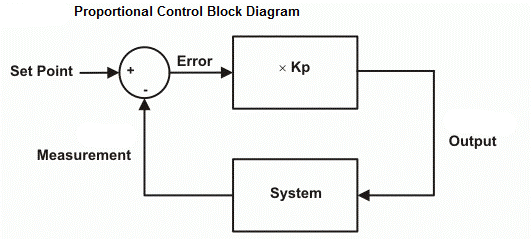

In [5]:
class PController(Controller):
    """
    In the below proportional control implementation, the controller output is proportional to the error signal,  which is the difference
    between the reference_idx and the state_idx .i.e., the output of a proportional controller
    is the multiplication product of the error signal and the proportional gain.Here kp =10 is assumed for proportionality gain.

    Valid for DC Motor System
    """

    def __init__(self, environment, k_p=10, controller_no=0, state_idx=None, reference_idx=0):
        action_space = environment.action_space
        assert type(action_space) is Box and type(
            environment.physical_system) is DcMotorSystem, 'No suitable action space for P Controller'
        self._k_p = k_p
        self._controller_no = controller_no
        self._action_min = action_space.low[controller_no]
        self._action_max = action_space.high[controller_no]
        self._ref_idx = reference_idx
        if state_idx is None:
            self._referenced_state = np.argmax(
                environment.reference_generator.referenced_states[environment.state_filter]
            )
        else:
            self._referenced_state = state_idx

    def control(self, state, reference):
        return np.array([
            max(
                self._action_min,
                min(
                    self._action_max,
                    self._k_p * (reference[self._ref_idx] - state[self._referenced_state])
                )
            )
        ])


The response of 'DCSeriesCont-V1' motor from the motor environments from gem-toolbox with P-Controller is as follows:

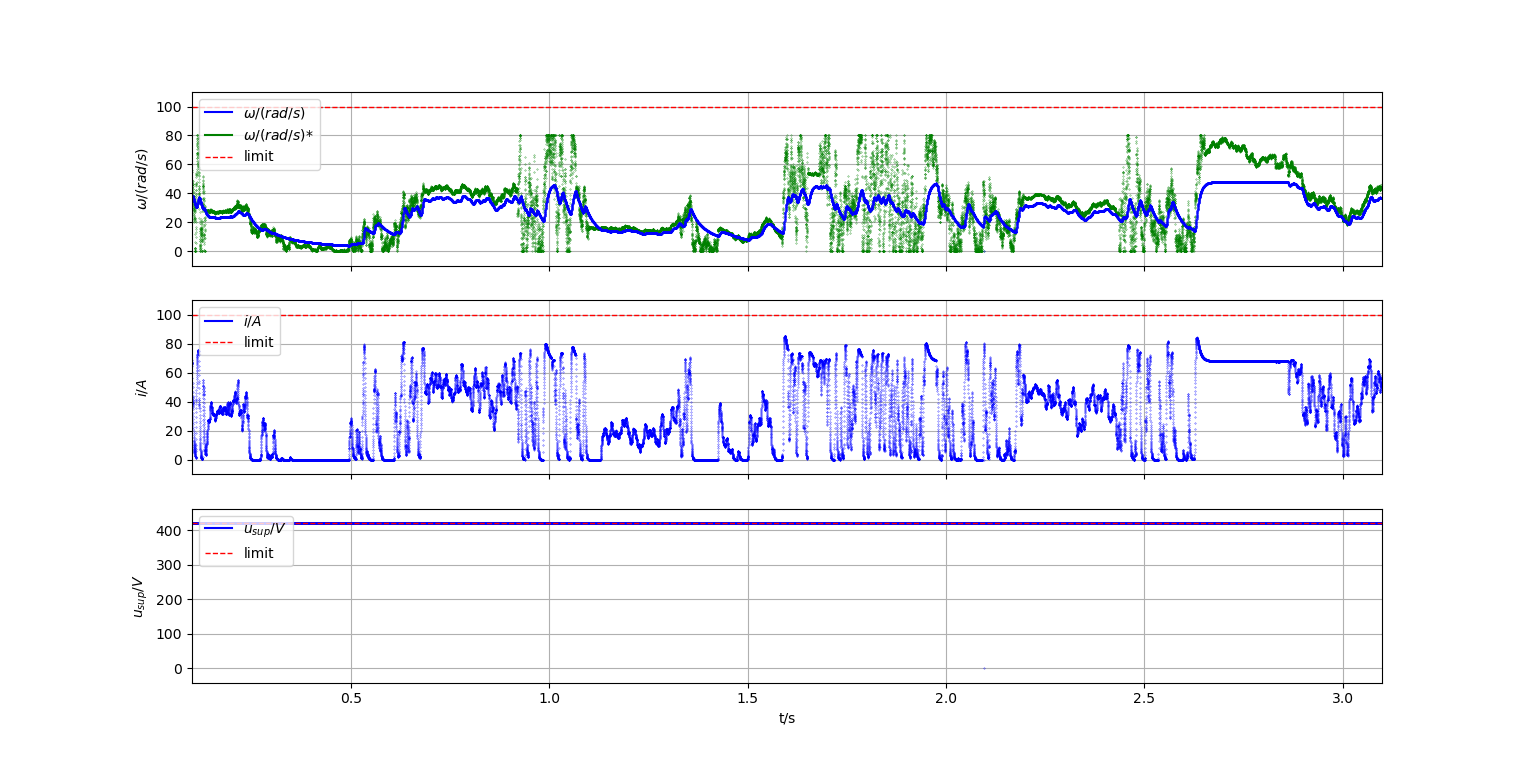

## Integral Control

The integral controller produces an output, which is integral of the error signal.

If u(t) is the controller output and $K_I$ is the Integral Control gain constant and e(t) is the error.Then


$$u(t)=K_I\int e(t)dt$$


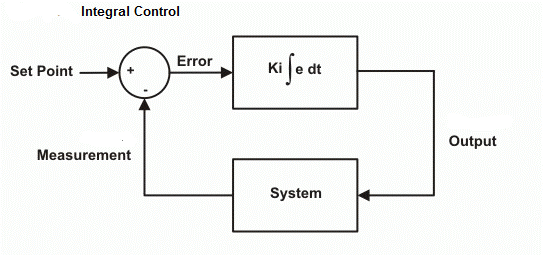

In [6]:
class IController(Controller):

    def __init__(self, environment, k_i=0.01, controller_no=0, state_idx=None, reference_idx=0):
        action_space = environment.action_space
        assert type(action_space) is Box and type(
            environment.physical_system) is DcMotorSystem, 'No Suitable action Space for I controller'
        self._k_i = k_i
        self._tau = environment.physical_system.tau
        self._integrated_value = 0
        self._limits = environment.physical_system.limits
        self._controller_no = controller_no
        self._action_min = action_space.low[controller_no]
        self._action_max = action_space.low[controller_no]
        self._ref_idx = reference_idx
        self._referenced_state = state_idx or np.argmax(environment.reference_generator.referenced_states)
        self._referenced_state_max = self._limits[self._referenced_state] \
                                     * environment.physical_system.state_space.high[self._referenced_state]
        self._referenced_state_min = self._limits[self._referenced_state] \
                                     * environment.physical_system.state_space.low[self._referenced_state]

    def control(self, state, reference):
        diff = reference[self._ref_idx] - state[self._referenced_state]
        self._integrated_value += diff * self._tau
        if self._integrated_value > self._referenced_state_max:  # check upper limit
            self._integrated_value = self._referenced_state_max
        else:
            self._integrated_value = self._integrated_value - diff * self._k_i  # anti-reset windup
        if self._integrated_value < self._referenced_state_min:  # check upper limit
            self._integrated_value = self._referenced_state_min
        else:
            self._integrated_value = self._integrated_value - diff * self._k_i  # anti-reset windup

        return np.array([
            max(
                self._action_min,
                min(
                    self._action_max, self._k_i * self._integrated_value
                )
            )
        ])

    def reset(self, **__):
        self._integrated_value = 0

## Derivative Controller

As the name suggests,the output of the controllers is directly proportional to the derivative of the error signal.

If u(t) is the controller output and $K_D$ is the derivative Control gain constant ,e(t) is the error,then


$$u(t)=K_D\frac{\text{d} e(t)}{dt}$$


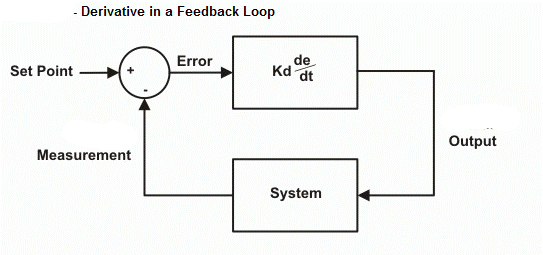

In [7]:
class DController(Controller):

    def __init__(self, environment, k_d=1, controller_no=0, state_idx=None, reference_idx=0):
        self._derivative_value = 0
        self._tau = environment.physical_system.tau
        self._prev_error = 0
        action_space = environment.action_space
        assert type(action_space) is Box and type(
            environment.physical_system), 'No suitable action space for P Controller'
        self._k_d = k_d
        self._controller_no = controller_no
        self._tau = environment.physical_system.tau
        self._action_min = action_space.low[controller_no]
        self._action_max = action_space.high[controller_no]
        self._limits = environment.physical_system.limits
        self._ref_idx = reference_idx
        self._referenced_state = state_idx or np.argmax(environment.reference_generator.referenced_states)
        self._referenced_state_max = self._limits[self._referenced_state] \
                                     * environment.physical_system.state_space.high[self._referenced_state]
        self._referenced_state_min = self._limits[self._referenced_state] \
                                     * environment.physical_system.state_space.low[self._referenced_state]

    def control(self, state, reference):
        diff = reference[self._ref_idx] - state[self._referenced_state]
        de = diff - self._prev_error
        self._derivative_value = de / self._tau
        self._prev_error = diff
        return np.array([
               max(
                   self._action_min,
                   min(
                      self._action_max,
                      self._k_d * self._derivative_value
                   )
               )
            ])

    def reset(self, **__):
        self._derivative_value = 0

The response of 'DCSeriesCont-V1' motor from the motor environments from gem-toolbox with Derivative Controller is as follows:

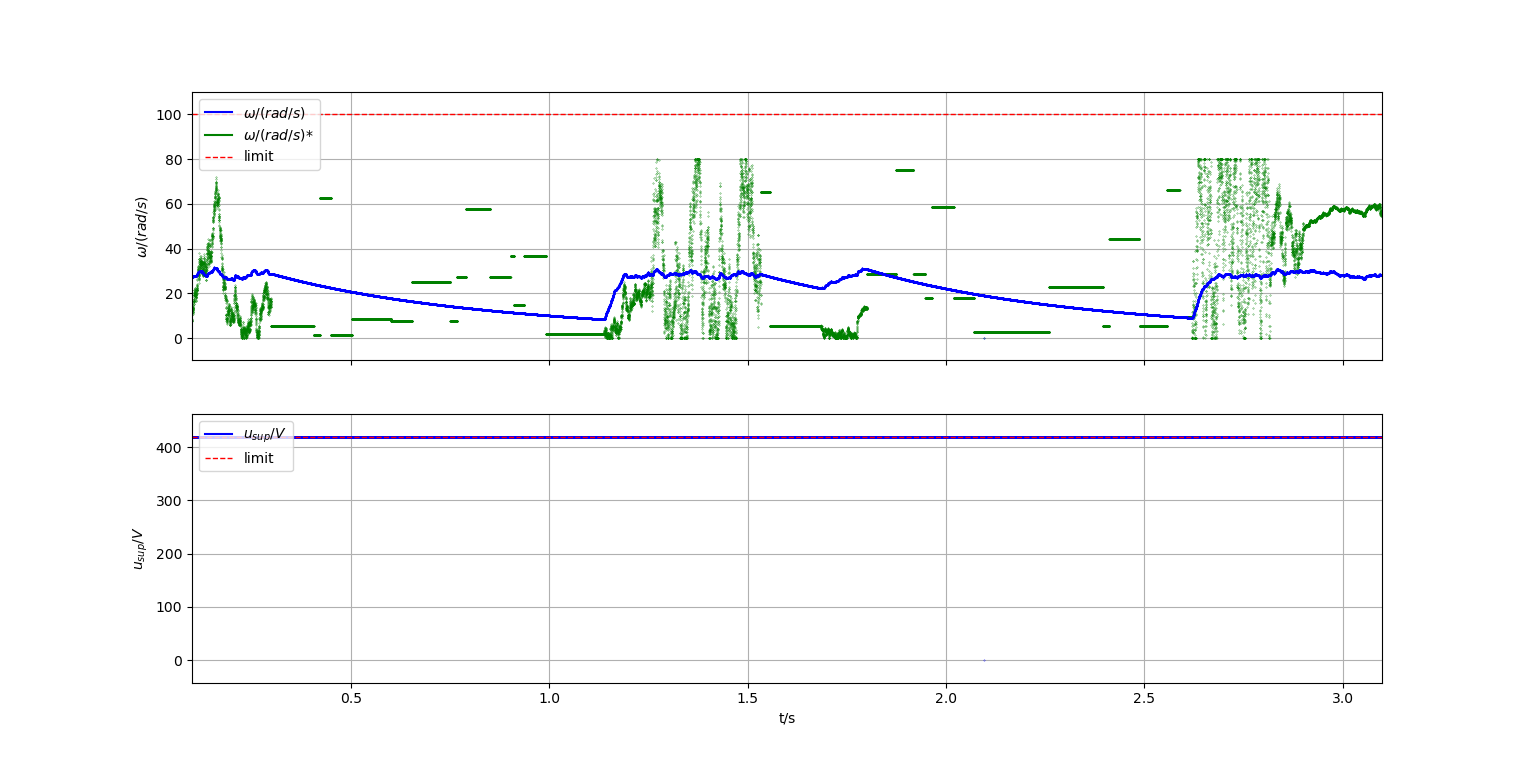

## PI Controller

Proportional Integral (PI) Controller is a combination of proportional and an integral controller the output (also called the actuating signal) is equal to the summation of proportional and integral of the error signal.

If u(t) is the controller output and $K_P$ and $K_I$ are the Proportional Control gain Constant and the integral Control gain constants respectively , and e(t) is the error. Then

$$u(t)=K_Pe(t)+K_I\int e(t)dt$$


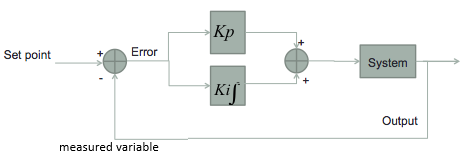


In [9]:
class PIController(PController):
    """
      The below Discrete PI Controller performs discrete-time PI controller computation using the error signal and proportional
      and integral gain inputs. The error signal is the difference between the reference_idx and the referenced_state.
      It outputs a weighted sum of the input error signal and the integral of the input error signal.

      Valid for DC Motor System
    """

    def __init__(self, environment, k_p=10, k_i=0.01, controller_no=0, reference_idx=0):
        super().__init__(environment, k_p, controller_no, reference_idx)
        action_space = environment.action_space
        assert type(action_space) is Box and type(
            environment.physical_system) is DcMotorSystem, 'No suitable action space for PI Controller'
        self._k_i = k_i
        self._ref_idx = reference_idx
        self._tau = environment.physical_system.tau
        self._limits = environment.physical_system.limits
        self._integrated_value = 0
        self._referenced_state_max = self._limits[self._referenced_state] \
                                     * environment.physical_system.state_space.high[self._referenced_state]
        self._referenced_state_min = self._limits[self._referenced_state] \
                                     * environment.physical_system.state_space.low[self._referenced_state]
        self._motor_parameter = environment.physical_system.electrical_motor.motor_parameter

    def control(self, state, reference):
        diff = reference[self._ref_idx] - state[self._referenced_state]
        self._integrated_value += diff * self._tau
        if self._integrated_value > self._referenced_state_max:  # check upper limit
            self._integrated_value = self._referenced_state_max
        else:
            self._integrated_value = self._integrated_value - diff * self._tau  # anti-reset windup
        if self._integrated_value < self._referenced_state_min:  # check lower limit
            self._integrated_value = self._referenced_state_min
        else:
            self._integrated_value = self._integrated_value - diff * self._tau  # anti-reset windup

        return np.array([
            max(
                self._action_min,
                min(
                    self._action_max,
                    self._k_p * (reference[self._ref_idx] - state[self._referenced_state])
                    + self._k_i * self._integrated_value
                )
            )
        ])

    def reset(self, **__):
        self._integrated_value = 0


The response of 'DCSeriesCont-V1' motor from the motor environments from gem-toolbox with PI Controller is as follows:

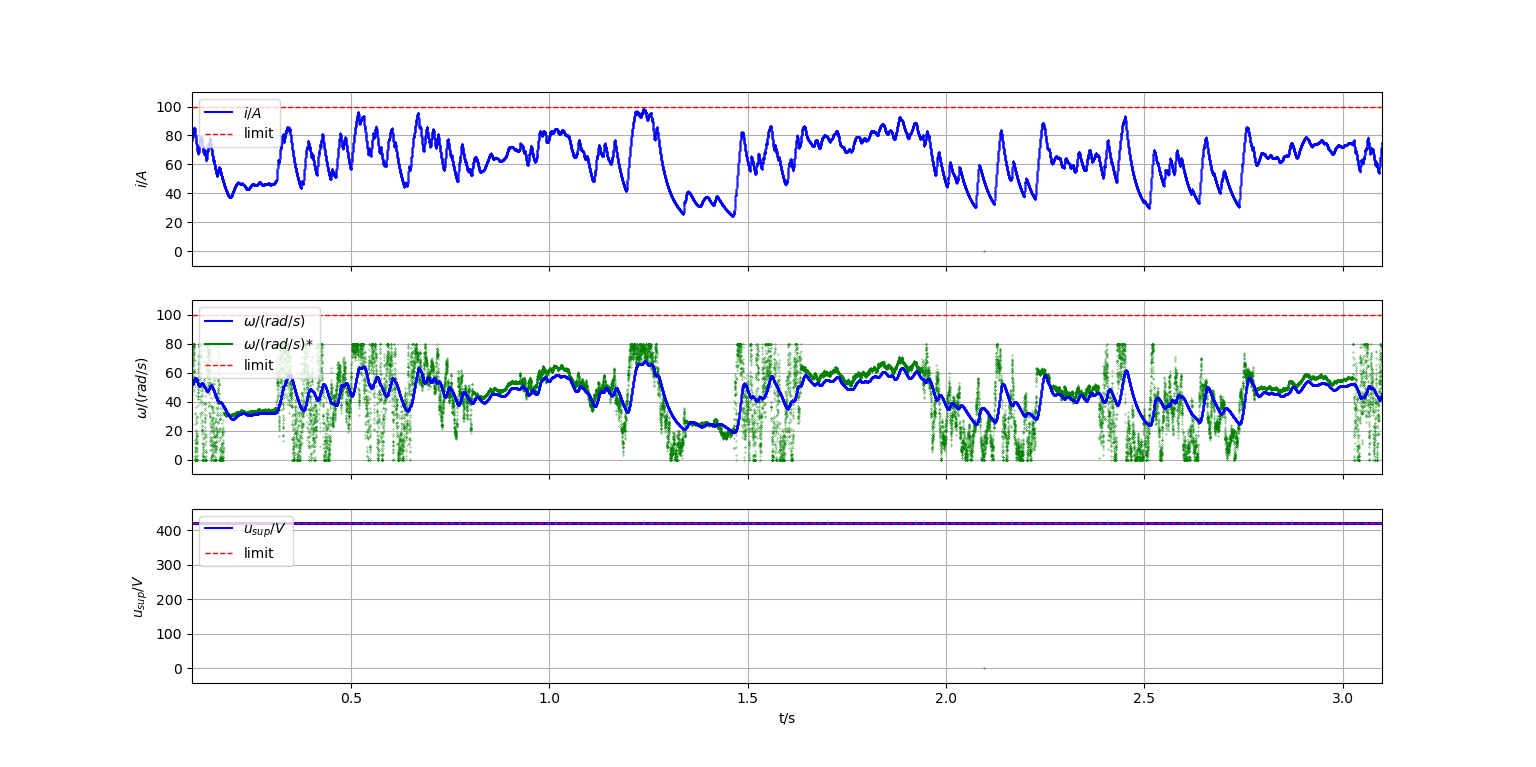

## PID Controller

The proportional integral derivative controller produces an output, which is the combination of the outputs of proportional, 
integral and derivative controllers.

If u(t) is the controller output,$K_P$,$K_D$ and $K_I$ are the Proportional Control gain Constant,Derivative control gain constant and the integral Control gain constants respectively , and e(t) is the error. Then

$$u(t)=K_P e(t)+K_I\int e(t)dt+K_D\frac{\text{d} e(t)}{dt}$$


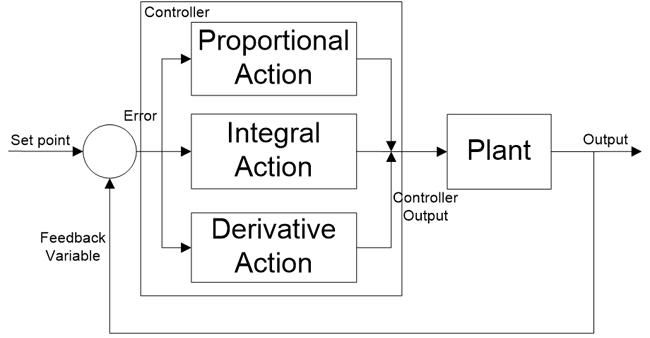


In [10]:
class PIDController(PIController):
    """
      The below Discrete PI Controller performs discrete-time PI controller computation using the error signal and proportional
      and integral gain inputs. The error signal is the difference between the reference_idx and the referenced_state.
      It outputs a weighted sum of the input error signal and the integral of the input error signal.
      Valid for DC Motor System
    """

    def __init__(self, environment, k_p=10, k_i=0.01, k_d=1, controller_no=0, reference_idx=0):
        super().__init__(environment, k_p, k_i, controller_no, reference_idx)
        self._ref_dx = reference_idx
        action_space = environment.action_space
        assert type(action_space) is Box and type(
            environment.physical_system) is DcMotorSystem, 'No suitable action space for PI Controller'
        self._k_i = k_i
        self._k_d = k_d
        self._k_p = k_p
        self._tau = environment.physical_system.tau
        self._limits = environment.physical_system.limits
        self._integrated_value = 0
        self._derivative_value = 0
        self._prev_error = 0
        self._current_time = time.time()
        self._prev_time = self._current_time
        self._referenced_state_max = self._limits[self._referenced_state] \
                                     * environment.physical_system.state_space.high[self._referenced_state]
        self._referenced_state_min = self._limits[self._referenced_state] \
                                     * environment.physical_system.state_space.low[self._referenced_state]

    def control(self, state, reference):
        diff = reference[self._ref_idx] - state[self._referenced_state]
        de = diff - self._prev_error
        self._derivative_value = de/self._tau
        diff = reference[self._ref_idx] - state[self._referenced_state]
        self._integrated_value += diff * self._tau
        self._prev_error = diff
        self._prev_time = self._current_time
        if self._integrated_value > self._referenced_state_max:  # check upper limit
            self._integrated_value = self._referenced_state_max
        else:
            self._integrated_value = self._integrated_value - diff * self._tau  # anti-reset windup
        if self._integrated_value < self._referenced_state_min:  # check lower limit
            self._integrated_value = self._referenced_state_min
        else:
            self._integrated_value = self._integrated_value - diff * self._tau  # anti-reset windup
        return np.array([
                max(
                    self._action_min,
                    min(
                        self._action_max,
                        (self._k_p * (reference[self._ref_dx] - state[self._referenced_state]))
                        + (self._k_i * self._integrated_value) + (self._k_d * self._derivative_value)
                    )
                )
            ])

    def reset(self, **__):
        self._integrated_value = 0

The response of 'DcPermExCont-v1' motor from the motor environments from gem-toolbox with PID Controller is as follows:

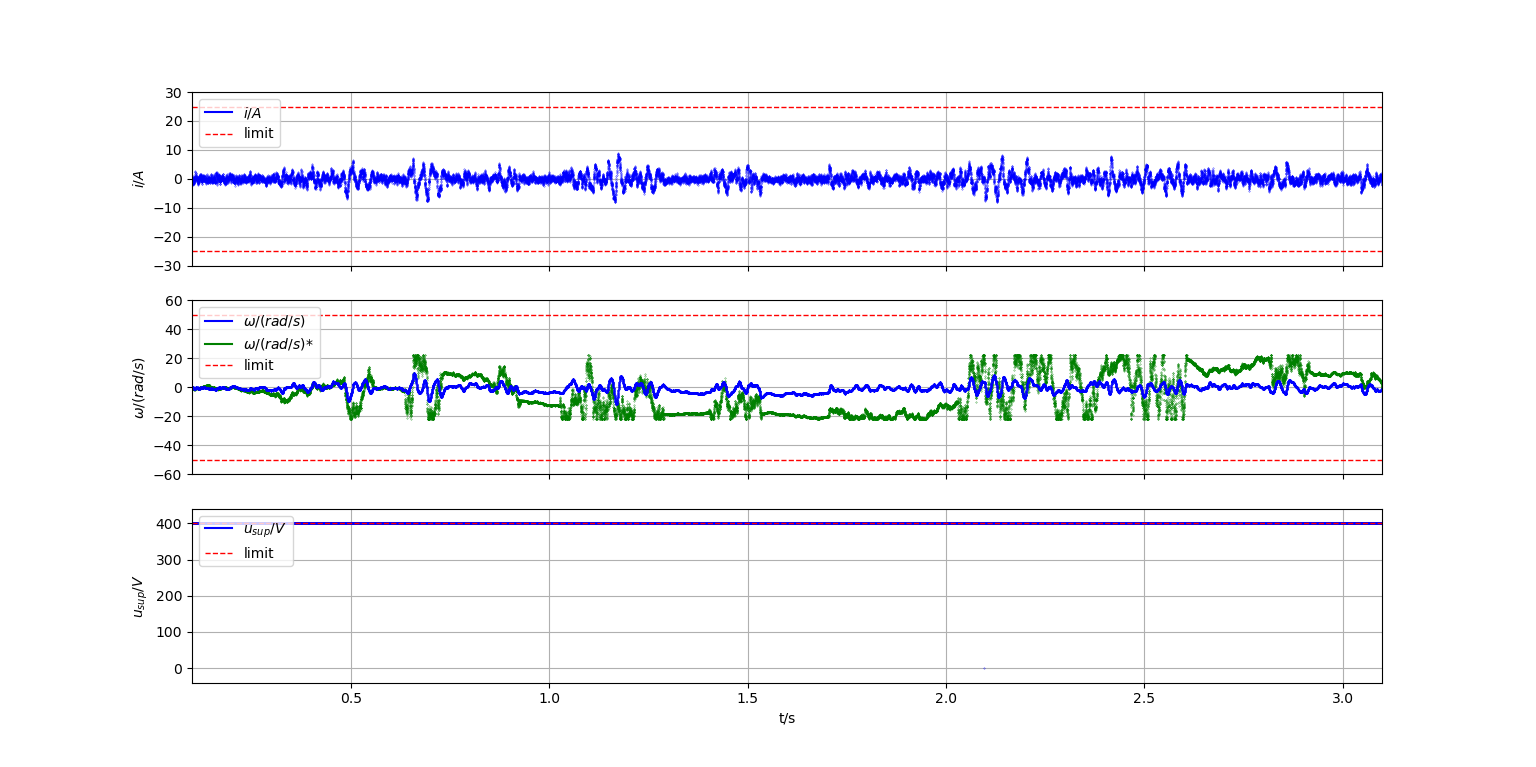

## Cascaded PI Control

Cascade control involves the use of two controllers with the output of the first controller providing the setpoint for the second controller, the feedback loop for one controller nestling inside the other.Such a system can give a improved 
response to disturbances.
Cascade control uses an additional,"secondary" measured process input variable that has the im
portant characteristic that it indicates the occurrence of the key disturbance.
The secondary controller set point is equal to the primary controller output. 


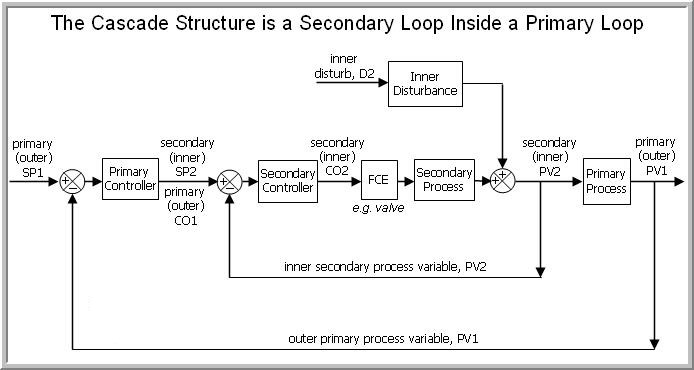

In [11]:
class DCCascadedPIController(Controller):
    """
      cascade architecture has: two controllers (an inner secondary and outer primary controller)
      two measurement/state variable sensors (an inner PV2 and outer PV1).A primary or master controller generates a 
      control effort that serves as the reference for a secondary or slave controller.That controller in turn uses the
      actuator to apply its control effort directly to the secondary process.The secondary process then generates a 
      secondary process variable that serves as the control effort for the primary process. The geometry of this
      defines an inner loop involving the current controller and an outer loop involving the speed controller.The 
      inner loop functions like a traditional feedback control system with a reference variable, a measured variable,
      and a controller acting on a process by means of an actuator. The outer loop does the same except that it uses 
      the entire inner loop as its actuator.

      Valid for DcMotorSystem Only
    """

    def __init__(self, environment, ref_idx=0):
        assert type(environment.physical_system) is DcMotorSystem
        self._omega_idx = np.argmax(environment.state_names == 'omega')
        self._currents_idx = environment.physical_system.CURRENTS_IDX
        self._voltages_idx = environment.physical_system.VOLTAGES_IDX
        self._u_a_idx = self._voltages_idx[0]
        self._i_a_idx = self._currents_idx[0]
        self._u_sup = environment.physical_system.supply.u_nominal
        if len(self._currents_idx) > 1:
            self._i_e_idx = np.argmax(np.array(environment.state_names) == 'i_e')
        else:
            self._i_e_idx = np.argmax(np.array(environment.state_names) == 'i')
        if len(self._voltages_idx) > 1:
            self._u_e_idx = np.argmax(np.array(environment.state_names) == 'u_e')
        else:
            self._u_e_idx = None
        self._limits = environment.physical_system.limits[environment.state_filter]
        self._ref_idx = ref_idx
        self._tau = environment.physical_system.tau
        mp = environment.physical_system.electrical_motor.motor_parameter
        t_motor = mp['l_a'] / mp['r_a']
        t_t = 3 / 2 * self._tau
        r_motor = mp['r_a']
        self._i_a_max = 0
        self._i_a_min = 0
        self._u_a_max = 0
        self._u_a_min = 0
        self._integrated_values = [0, 0]
        self._converter_voltages = environment.physical_system.converter.voltages
        self._i_a_max = self._limits[self._i_a_idx] * environment.physical_system.state_space.high[self._i_a_idx]
        self._i_a_min = self._limits[self._i_a_idx] * environment.physical_system.state_space.low[self._i_a_idx]
        if 'psi_e' in mp.keys():
            self._psi_e = mp['psi_e']
            self._i_e_max_prime = None
        elif 'l_e_prime' in mp.keys():
            self._psi_e = None
            self._i_e_max_prime = self._limits[self._currents_idx[-1]] * mp['l_e_prime']
        else:
            raise Exception('Motor Parameter Error. No psi_e and no l_e_prime entry found in motor parameters')
        self._u_a_max = self._limits[self._u_a_idx] * environment.physical_system.state_space.high[self._u_a_idx]
        self._u_a_min = self._limits[self._u_a_idx] * environment.physical_system.state_space.low[self._u_a_idx]
        # compute motor type specific parameter
        # use inner_ and outer_gain_adjustment to adjust the integral part gains for better control behaviour
        # Gains chosen as given in "Elektrische Antriebe - Regelung von Antriebssystemen", D. Schröder, 2009
        if type(environment.physical_system.electrical_motor) == DcPermanentlyExcitedMotor:
            inner_gain_adjustment = 1e-3
            outer_gain_adjustment = 1e-3
        elif type(environment.physical_system.electrical_motor) == DcSeriesMotor:
            t_motor = (mp['l_a'] + mp['l_e']) / (mp['r_a'] + mp['r_e'])
            r_motor = (mp['r_a'] + mp['r_e'])

            inner_gain_adjustment = 1
            outer_gain_adjustment = 1

        elif type(environment.physical_system.electrical_motor) == DcExternallyExcitedMotor:
            inner_gain_adjustment = 1E-4
            outer_gain_adjustment = 1E-3

        elif type(environment.physical_system.electrical_motor) == DcShuntMotor:
            inner_gain_adjustment = 1E-2
            outer_gain_adjustment = 1
        else:
            raise Exception('Unknown Motor')

        # set up gains for the controller
        # Integral gains are multiplied by the sampling time to simplify the computation during control

        t_sigma = min(t_motor, t_t)
        t_1 = max(t_motor, t_t)
        v_s = 1 / r_motor
        # Integral Inner loop
        self._k_i_i = 1 / (2 * t_sigma * v_s) * self._tau * inner_gain_adjustment
        # Proportional Inner loop
        self._k_p_i = t_1 / (2 * t_sigma * v_s)
        # Integral Outer loop
        j = environment.physical_system.mechanical_load.j_total
        self._k_i_o = (
                j / (32 * t_sigma ** 2)
                * self._tau * outer_gain_adjustment
        )
        # Proportional Outer loop
        self._k_p_o = j / (4 * t_sigma)

    def control(self, state, reference):
        # denormalize quantities
        omega = state[self._omega_idx] * self._limits[self._omega_idx]
        omega_ref = reference[self._ref_idx] * self._limits[self._omega_idx]
        i_a = state[self._i_a_idx] * self._limits[self._i_a_idx]
        psi_e = self._psi_e or state[self._i_e_idx] * self._i_e_max_prime

        # outer control loop
        d_omega = omega_ref - omega
        if psi_e != 0:
            temp = self._integrated_values[0] + d_omega * self._k_i_o / psi_e  # integral part
            i_a_des = temp + d_omega * self._k_p_o / psi_e
        else:
            i_a_des = math.copysign(1, d_omega) * self._i_a_max
            temp = self._integrated_values[0]

        # hold current constraints, anti wind-up
        if i_a_des > self._i_a_max or i_a_des < self._i_a_min:
            i_a_des = min(max(i_a_des, self._i_a_min), self._i_a_max)
        else:
            self._integrated_values[0] = temp

        d_i_a = i_a_des - i_a
        # inner control loop
        temp = self._integrated_values[1] + d_i_a * self._k_i_i  # integral part
        d_u_a = temp + d_i_a * self._k_p_i
        u_a_0 = omega * psi_e
        u_a = d_u_a + u_a_0

        # hold voltage limits, anti wind-up
        if u_a > self._u_a_max or u_a < self._u_a_min:
            u_a = min(max(u_a, self._u_a_min), self._u_a_max)
        else:
            self._integrated_values[1] = temp

        # normalize the desired output voltage to a duty cycle referring to the supply voltage
        # Assumption: u_sup = u_N is made

        des_duty_cycle = u_a / self._limits[self._u_a_idx]
        # Voltage compensation
        u_sup_avg = (self._u_sup * self._tau) / self._tau
        des_duty_cycle = des_duty_cycle * (u_sup_avg / self._u_sup)
        duty_cycle = min(
            max(des_duty_cycle, self._u_a_min / self._limits[self._u_a_idx]),
            self._u_a_max / self._limits[self._u_a_idx])
        return np.array([duty_cycle])

The response of 'DCSeriesCont-V1' motor from the motor environments from gem-toolbox with Cascaded PI Controller is as follows:
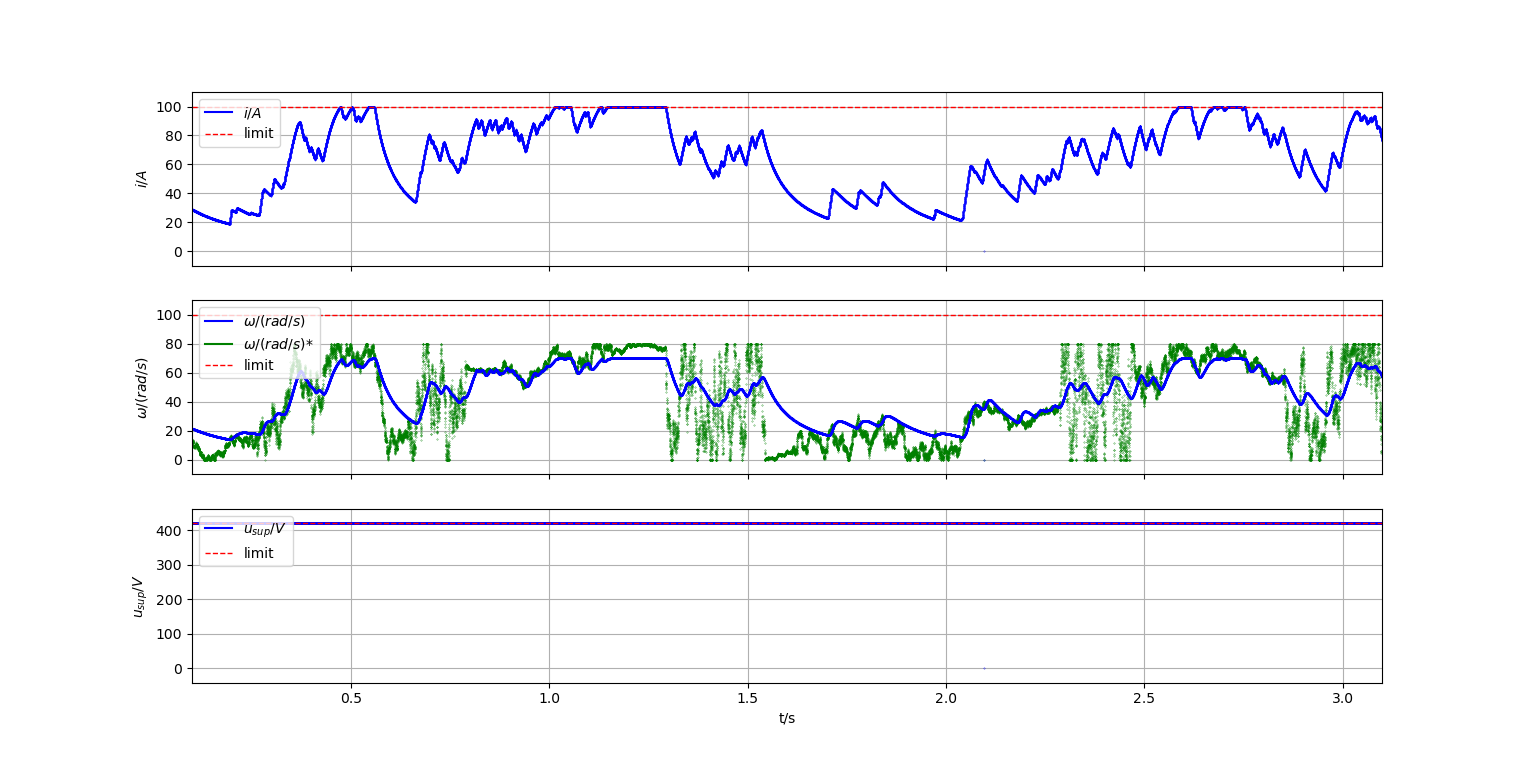

## FOC Controller

A standard AC motor contoller is the FOC Controller.This motor control has the ability to separate
the control of the flux and the torque. The controller structure is a cascaded controller,
which two different controllers is connected in serial. The outer controller
is the speed controller, which takes as input the speed reference and regulates the
synchronization current accordingly. The inner controller is the current controller,
which control the current and inturn regulates the terminal voltages at the stator.
In field-oriented controller, the measured phase current is translated into dq- frame.
The benefit of this transformation is the dq frame rotates with the rotor position
angle, so that the phase current acts like DC currents, which is not dependent on the
rotor position. There will be two transformations,abc-$\alpha\beta$ (Clark transformation) and another from $\alpha\beta$ -dq(Park transformation).Through these switching of currents from abc-dq using the above mentioned 
transformations,the control of the currents is made easier.

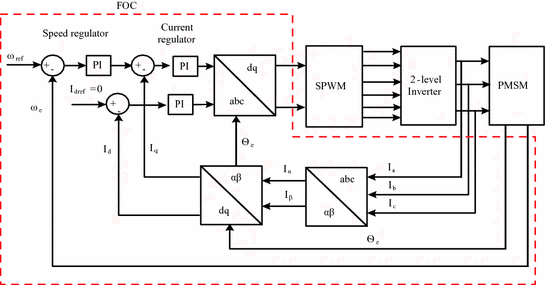

A PI-Controller is used for controlling both the currents.The outputs of the current controller are then transformed back
into abc frame and fed to Pulse Width Modulation (PWM)/SVM. Finally, PWM switches
the transistor on the Voltage Source Inverter to produce three phase sinusoidal voltages on the motor terminals.



In [ ]:
class FOCController(Controller):
    """
    FOC is used to control AC synchronous and induction motors.The stator currents of a three-phase AC electric motor are identified
    as two orthogonal components that can be visualized with a vector. One component defines the magnetic flux of the motor, the other the torque.
    The control system of the drive calculates the corresponding current component references from the flux and torque references given
    by the drive's speed control.

    """

    def __init__(self, environment, ref_idx=0, weight=1, dq_decoupling=False):
        assert type(environment.physical_system) is SynchronousMotorSystem
        self._dq_decoupling = dq_decoupling  # Can be turned ON
        self._ref_idx = ref_idx
        self._weight = weight
        self._omega_idx = np.argmax(np.array(environment.state_names) == 'omega')
        self._currents_idx = np.zeros(2, dtype=int)
        self._currents_idx[0] = np.argmax(np.array(environment.state_names) == 'i_sq')
        self._currents_idx[1] = np.argmax(np.array(environment.state_names) == 'i_sd')
        self._voltages_idx = np.zeros(2, dtype=int)
        self._voltages_idx[0] = np.argmax(np.array(environment.state_names) == 'u_sq')
        self._voltages_idx[1] = np.argmax(np.array(environment.state_names) == 'u_sd')
        self._epsilon_idx = np.argmax(np.array(environment.state_names) == 'epsilon')
        self._limits = environment.physical_system.limits[environment.state_filter]
        self._tau = environment.physical_system.tau
        t32 = environment.physical_system.electrical_motor.t_32
        q = environment.physical_system.electrical_motor.q
        t23 = environment.physical_system.electrical_motor.t_23
        q_inv = environment.physical_system.electrical_motor.q_inv
        self._forward_transformation = lambda quantities, eps: q_inv(t23(quantities), eps)[::-1]
        self._backward_transformation = (
            lambda quantities, eps: t32(q(quantities[::-1], eps))
        )
        self._motor_parameter = environment.physical_system.electrical_motor.motor_parameter
        mp = self._motor_parameter

        # current controller i_d
        t_motor_d = mp['l_d'] / mp['r_s']
        tau = environment.physical_system.tau
        t_t = 3 / 2 * tau
        t_1_d = max(t_motor_d, t_t)
        t_sigma_d = min(t_motor_d, t_t)
        v_s_d = 1 / mp['r_s']

        # current controller i_q
        t_motor_q = mp['l_q'] / mp['r_s']
        t_1_q = max(t_motor_q, t_t)
        t_sigma_q = min(t_motor_q, t_t)
        v_s_q = 1 / mp['r_s']

        # outer speed controller
        t_2 = 2 * t_sigma_q
        t_1_s = environment.physical_system.mechanical_load.j_total
        v_s_s = 3 / 2 * mp['p'] * mp['psi_p']

        self._k_i_t = 2 * t_1_s / v_s_s * tau  # integral gain speed controller.
        self._k_p_t = t_1_s / (2 * t_2 * v_s_s)  # prop. gain speed controller
        self._k_i_d = 1 / (2 * t_sigma_d * v_s_d) * tau  # integral gain i_sd controller.
        self._k_p_d = t_1_d / (2 * t_sigma_d * v_s_d)  # prop. gain i_sd controller
        self._k_i_q = 1 / (2 * t_sigma_q * v_s_q) * tau  # integral gain i_sq controller.
        self._k_p_q = t_1_q / (2 * t_sigma_q * v_s_q)  # prop. gain i_sq controller

        # specify max values for normalisation and anti wind up
        # an anti wind up scheme is necessary for good control behaviour to limit the integral parts in case of
        # limit violations of the desired input voltage

        # maximum speed without flux weakening
        self._omega_1 = (
                self._limits[self._voltages_idx][0] / mp['l_q'] / np.sqrt(self._limits[self._currents_idx][0]) ** 2
                + mp['psi_p'] ** 2 / mp['l_q'] ** 2
        )
        self._integrated_values = [0, 0, 0]

    def reset(self):
        self._integrated_values = [0, 0, 0]

    def control(self, state, reference):
        """
        Field oriented control from the lecture "controlled three phase drives, chapter 5"
        """

        # extract quantities from state
        mp = self._motor_parameter
        omega = state[self._omega_idx] * self._limits[self._omega_idx]
        omega_ref = reference[self._ref_idx] * self._limits[self._omega_idx]

        # u = state[self._voltages_idx] * self._limits[self._voltages_idx]
        epsilon = state[self._epsilon_idx] * self._limits[self._epsilon_idx]
        i_qd = state[self._currents_idx] * self._limits[self._currents_idx]

        # compute u_d_0 and u_q_0
        u_d_0 = omega * mp['l_q'] * i_qd[0]
        u_q_0 = omega * (mp['psi_p'] + mp['l_d'] * i_qd[1])
        d_omega = omega_ref - omega

        # compute T* (Torque reference) and i*_sq (q-axis current reference)
        temp = self._integrated_values[0] + d_omega * self._k_i_t  # integral part
        t_des = temp + d_omega * self._k_p_t  # proportional part
        i_sq_des = 2 * t_des / (3 * mp['p'] * mp['psi_p'])
        # anti wind-up
        if i_sq_des > self._limits[self._currents_idx[0]] * self._weight \
                or i_sq_des < -self._limits[self._currents_idx[0]] * self._weight:
            i_sq_des = min(
                max(i_sq_des, -self._limits[self._currents_idx[0]] * self._weight),
                self._limits[self._currents_idx[0]] * self._weight
            )
        else:
            self._integrated_values[0] = temp

        if abs(omega_ref) < self._omega_1:
            i_sd_des = 0
        else:
            i_sd_des = (
                    (self._limits[self._voltages_idx[0]] / omega_ref) ** 2
                    - (mp['l_q'] * self._limits[self._currents_idx[0]]) ** 2 - mp['psi_p'] ** 2
                    / (2 * mp['psi_p'] * mp['l_d']))

        # transform back to abc-domain
        currents = self._backward_transformation((i_sq_des, i_sd_des), epsilon)

        # test if current limits are violated
        if np.max(np.abs(currents)) > self._limits[self._currents_idx[0]]:
            clipping = self._limits[self._currents_idx[0]]
            currents = np.clip(currents, -clipping, clipping)
            array = self._forward_transformation(currents, epsilon)
            i_sd_des = array[1]
            i_sq_des = array[0]

        # compute du*_sq, du*_sd
        d_i_sd = i_sd_des - i_qd[1]
        d_i_sq = i_sq_des - i_qd[0]
        temp_u_sd = self._integrated_values[1] + d_i_sd * self._k_i_d  # integral part
        temp_u_sq = self._integrated_values[2] + d_i_sq * self._k_i_q  # integral part
        d_u_sd_des = temp_u_sd + d_i_sd * self._k_p_d
        d_u_sq_des = temp_u_sq + d_i_sq * self._k_p_q
        # anti-wind-up u_sd
        if d_u_sd_des > self._limits[self._voltages_idx[0]] * self._weight - u_d_0 or \
                d_u_sd_des < -self._limits[self._voltages_idx[0]] * self._weight - u_d_0:
            d_u_sd_des = np.clip(d_u_sd_des, -self._limits[self._voltages_idx[0]] * self._weight - u_d_0,
                                 self._limits[self._voltages_idx[0]] * self._weight - u_d_0)
        else:
            self._integrated_values[1] = temp_u_sd
        # anti-wind-up u_sq
        if d_u_sq_des > self._limits[self._voltages_idx[0]] * self._weight - u_q_0 or \
                d_u_sq_des < -self._limits[self._voltages_idx[0]] * self._weight - u_q_0:
            d_u_sq_des = np.clip(d_u_sq_des, -self._limits[self._voltages_idx[0]] * self._weight - u_q_0,
                                 self._limits[self._voltages_idx[0]] * self._weight - u_q_0)
        else:
            self._integrated_values[2] = temp_u_sq

        # compute u*_sq, u*_sd, epsilon + d_epsilon due to delay of the controller
        u_sd_des = u_d_0 + d_u_sd_des
        u_sq_des = d_u_sq_des + u_q_0
        epsilon_shift = epsilon + 3 / 2 * self._tau * omega

        # If we require dq-decoupling at higher speeds, the below block can be executed
        if self._dq_decoupling:
            u_sd_des = u_sd_des - u_d_0
            u_sq_des = u_sq_des + u_q_0
        else:
            u_sd_des = u_sd_des
            u_sq_des = u_sq_des

        # from d/q to alpha/beta and a/b/c
        u_qd_des = np.array([u_sq_des, u_sd_des])
        # voltages = self._backward_transformation(u_qd_des, epsilon_shift)

        # normalise inputs
        result = np.clip(u_qd_des / self._limits[self._voltages_idx[0]], -1, 1)
        print(result)
        return result

The response of PMSM motor -'emotor-pmsm-cont-v1' from the motor environments of gem toolbox with FOC Controller is as follows:

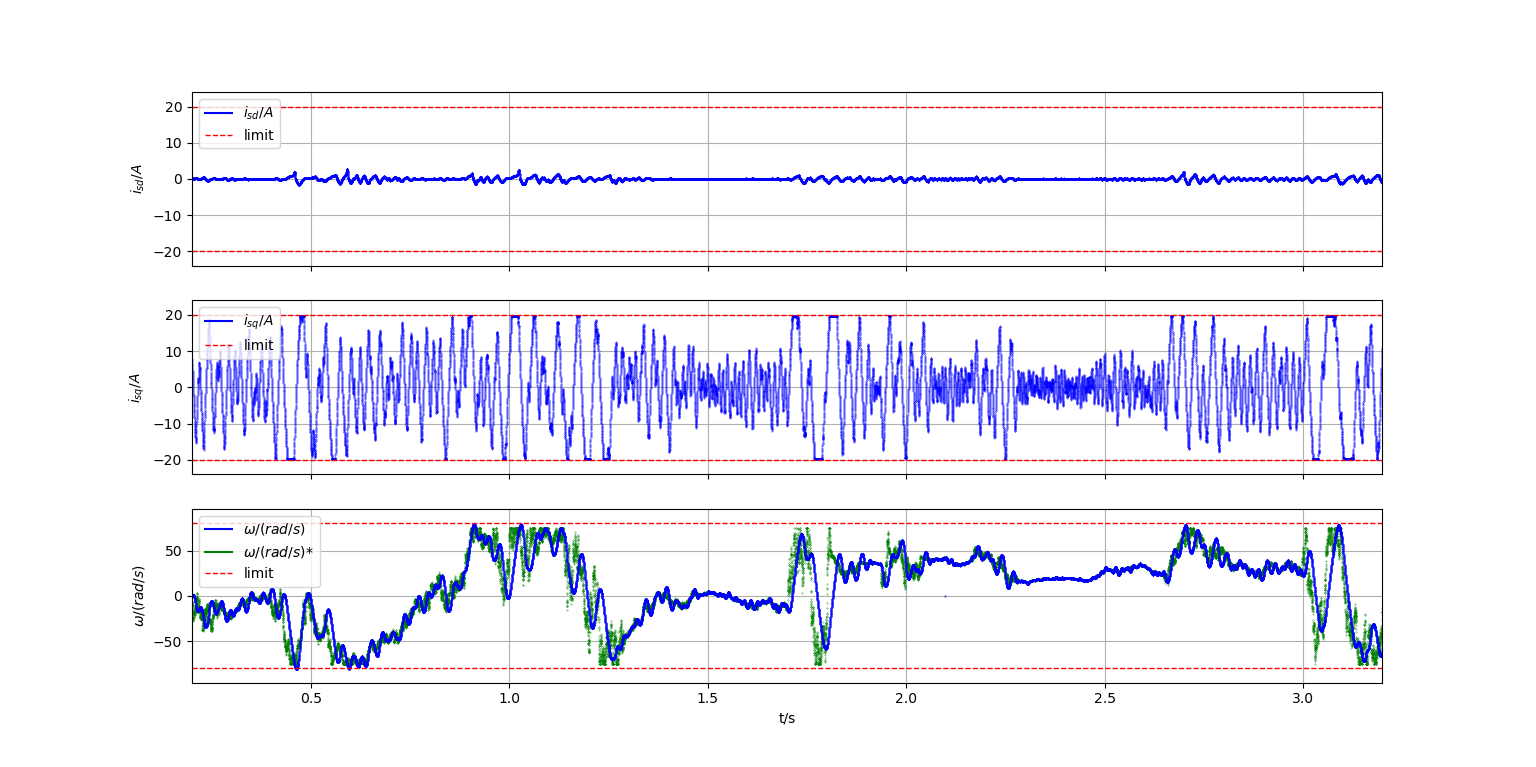

In [ ]:
class zero_voltage_injection:
    def __init__(self, environment, state_idx=None, ref_idx=0):
        self._omega_idx = environment.physical_system.OMEGA_IDX
        self._currents_idx = environment.physical_system.CURRENTS_IDX
        self._voltages_idx = environment.physical_system.VOLTAGES_IDX
        self._limits = environment.physical_system.limits
        self._tau = environment.physical_system.tau
        q = environment.physical_system.electrical_motor.q
        t23 = environment.physical_system.electrical_motor.t_23
        self._epsilon_idx = environment.physical_system.EPSILON_IDX
        self._limits = environment.physical_system.limits
        t32 = environment.physical_system.electrical_motor.t_3
        self._ref_idx = ref_idx
        self._referenced_state = state_idx or np.argmax(environment.reference_generator.referenced_states)
        q_inv = environment.physical_system.electrical_motor.q_inv
        self._forward_transformation = lambda quantities, eps: q_inv(t23(quantities), eps)[::-1]
        self._backward_transformation = (
            lambda quantities, eps: t32(q(quantities[::-1], eps))
        )

        self._motor_parameter = environment.physical_system.electrical_motor.motor_parameter

    def control(self, state):
        i = state[self._currents_idx] * self._limits[self._currents_idx]
        epsilon = state[self._epsilon_idx] * self._limits[self._epsilon_idx]
        i_qd = self._forward_transformation(i, epsilon)
        mp = self._motor_parameter
        omega = state[self._omega_idx] * self._limits[self._omega_idx]
        u_d_0 = omega * mp['l_q'] * i_qd[0]
        u_q_0 = omega * (mp['psi_p'] + mp['l_d'] * i_qd[1])
        u_a, u_b, u_c = self._backward_transformation((u_q_0, u_d_0), epsilon)
        voltages = [u_a, u_b, u_c]
        u_o = 1 / 2 * (max(voltages) + min(voltages))
        voltages[0] = voltages[0] - u_o
        voltages[1] = voltages[1] - u_o
        voltages[2] = voltages[2] - u_o
        result = np.clip(voltages / self._limits[self._voltages_idx[0]], -1, 1)
        return result


class PmsmPController(Controller):
    """
    In the below proportional control algorithm, the controller output is proportional to the error signal,  which is the difference
    between the reference_idx and the state_idx .i.e., the output of a proportional controller
    is the multiplication product of the error signal and the proportional gain
    Here kp =1 is assumed for a proportionality gain.

    """

    def __init__(self, environment, state_idx=None, ref_idx=0, k_p=1):
        self._k_p = k_p
        t32 = environment.physical_system.electrical_motor.t_32
        q = environment.physical_system.electrical_motor.q
        t23 = environment.physical_system.electrical_motor.t_23
        q_inv = environment.physical_system.electrical_motor.q_inv
        self._forward_transformation = lambda quantities, eps: q_inv(t23(quantities), eps)[::-1]
        self._backward_transformation = (
            lambda quantities, eps: t32(q(quantities[::-1], eps))
        )
        self._epsilon_idx = np.argmax(environment.state_names == 'epsilon')
        self._currents_idx = np.zeros(2)
        self._currents_idx[0] = np.argmax(environment.state_names == 'i_sq')
        self._currents_idx[1] = np.argmax(environment.state_names == 'i_sd')
        self._ref_idx = ref_idx
        if state_idx is None:
            self._referenced_state = np.argmax(
                environment.reference_generator.referenced_states[environment.state_filter]
            )
        else:
            self._referenced_state = state_idx
        self._phase = 0

    def control(self, state, reference):
        u_q = min(1, max(-1, self._k_p * reference[self._ref_idx] - state[self._referenced_state]))
        epsilon = np.pi * state[self._epsilon_idx]

        u_d = 0
        u_a, u_b, u_c = self._backward_transformation((u_q, u_d), epsilon)
        return [u_a, u_b, u_c]

    def reset(self):
        self._phase = 0




The below is a response of the 'PMSMCont-v1' from gym-tool box with PMSM-P Controller.The red lines indicate the mentioned limit values from corresponding motor environment from physical_systems/electrical_motors.py file are exceeded.
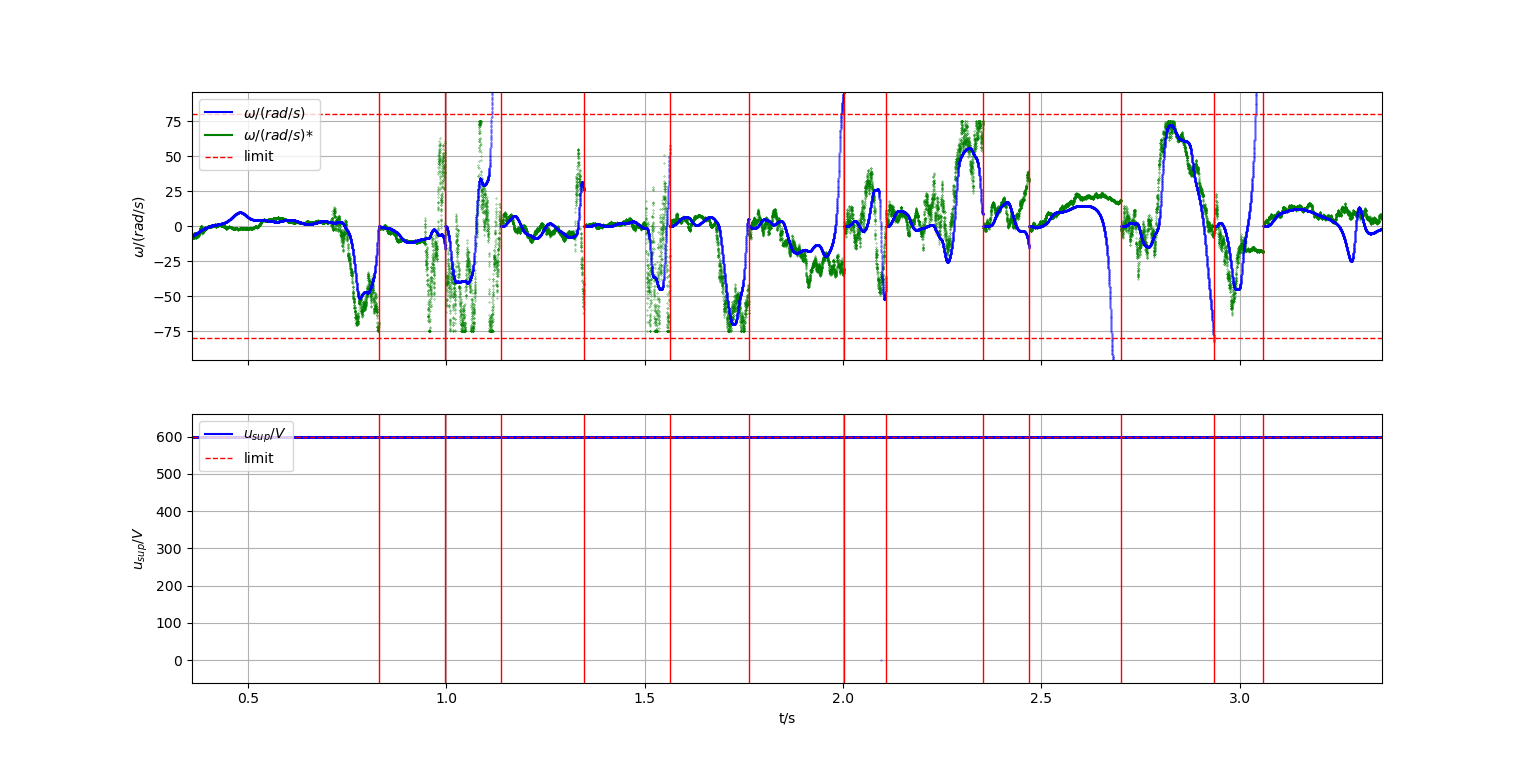

In [ ]:
class ThreePhaseSteadyState(Controller):
    """
    In the below control scheme, we have chosen a parameter 'k'= - 1. With every increase of k value, we calculate the length
    of u_a and we output the values as product of 'k' and length of u_a for each of u_a,u_b,u_c.
    """

    def __init__(self, environment, omega_el=15):
        self._omega_el = omega_el
        self._tau = environment.physical_system.tau
        self._k = 0
        t = np.linspace(0, 2 * np.pi / abs(omega_el), 1 / abs(omega_el * self._tau))
        self._u_a = np.sin(omega_el * t)
        self._u_b = np.sin(omega_el * t - 2 / 3 * np.pi)
        self._u_c = np.sin(omega_el * t + 2 / 3 * np.pi)

    def reset(self):
        self._k = -1

    def control(self, state, reference):
        self._k += 1
        length = len(self._u_a)
        return self._u_a[self._k % length], self._u_b[self._k % length], self._u_c[self._k % length],


_controllers = {
    'on_off': OnOffController,
    'three_point': ThreePointController,
    'p_controller': PController,
    'i_controller': IController,
    'pi_controller': PIController,
    'pid_controller': PIDController,
    'd_controller': DController,
    'pmsm_on_off': PmsmOnOffController,
    'synrm_on_off': SynRmOnOffController,
    'cascaded_pi': DCCascadedPIController,
    'foc_controller': FOCController,
    'pmsm_p_controller': PmsmPController,
    'three_phase_steadystate': ThreePhaseSteadyState